In [1]:
# RNN(Long Short-Term Memory, LSTM)

In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
import matplotlib.pyplot as plt
import os
%matplotlib inline

C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def mergeData():
    SaveFile_Name = 'data.csv'
    file_list = os.listdir('data')
    df = pd.read_csv('data'+'\\'+file_list[0])
    df.to_csv(SaveFile_Name,encoding="utf_8_sig",index=False)
    for i in range(1,len(file_list)):
        df = pd.read_csv('data'+'\\'+file_list[i])
        df.to_csv(SaveFile_Name,encoding="utf_8_sig",index=False, header=False, mode='a+')

In [3]:
def readData():
    train = pd.read_csv("data.csv")
    return train

In [4]:
def changeYear(data):
    for i in range(0,data.shape[0]):
        Date=data["日期"][i].split('/')
        year,month,date=Date[0],Date[1],Date[2]
        year=str(int(year)+1911)
        data.loc[i,"日期"]=year+'/'+month+'/'+date
    return data

In [5]:
# Augment Features
def augFeatures(data):
  data["日期"] = pd.to_datetime(data["日期"])
  data["年"] = data["日期"].dt.year
  data["月"] = data["日期"].dt.month
  data["日"] = data["日期"].dt.day
  data["第幾日"] = data["日期"].dt.dayofweek
  return data

In [6]:
def manage(data):
    for i in range(0,data.shape[0]):
        if data["漲跌價差"][i]=='X0.00':
            data.loc[i,"漲跌價差"]=str(int(data["收盤價"][i])-int(data["收盤價"][i-1]))
    data=data.drop(["日期"], axis=1)
    data=data.drop(["成交股數"], axis=1)
    data=data.drop(["成交金額"], axis=1)
    data=data.drop(["漲跌價差"], axis=1)
    data=data.drop(["成交筆數"], axis=1)
    data=data.convert_objects(convert_numeric=True)
    return data

In [7]:
from sklearn import preprocessing
def normalize(data):
    minmax_scale=preprocessing.MinMaxScaler(feature_range=(0,1))
    datanormalize=minmax_scale.fit_transform(data)
    return datanormalize

In [8]:
def buildTrain(train, pastDay=30, futureDay=1):
    X_train, Y_train, Z_train= [], [], []
    X,Y,Z=[],[],[]
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
        Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["開盤價"]))
        Z_train.append(np.array(train.iloc[i+pastDay-1:i+pastDay]["開盤價"]))
    X=np.array(X_train)
    Y=np.array(Y_train)
    Z=np.array(Z_train)
    Y=(Y-Z)/2
    Y_train=[]
    for i in range(len(Y)):
        if Y[i]<-5:
            Y_train.append(np.array([0]))
        elif -5<=Y[i]<-4:
            Y_train.append(np.array([1]))
        elif -4<=Y[i]<-3:
            Y_train.append(np.array([2]))
        elif -3<=Y[i]<-2:
            Y_train.append(np.array([3]))
        elif -2<=Y[i]<-1:
            Y_train.append(np.array([4]))
        elif -1<=Y[i]<0:
            Y_train.append(np.array([5]))
        elif 0<=Y[i]<1:
            Y_train.append(np.array([6]))
        elif 1<=Y[i]<2:
            Y_train.append(np.array([7]))
        elif 2<=Y[i]<3:
            Y_train.append(np.array([8]))
        elif 3<=Y[i]<4:
            Y_train.append(np.array([9]))
        elif 4<=Y[i]<5:
            Y_train.append(np.array([10]))
        elif 5<=Y[i]:
            Y_train.append(np.array([11]))
    Y=np.array(Y_train)
    return X, Y

In [9]:
def shuffle1(X,Y):
  np.random.seed()
  randomList = np.arange(X.shape[0])
  np.random.shuffle(randomList)
  return X[randomList], Y[randomList]

In [10]:
# 將Training Data取一部份當作Validation Data
def splitData(X,Y,rate):
    X_train = X[:-int(X.shape[0]*rate)]

    Y_train = Y[:-int(Y.shape[0]*rate)]
    
    X_val = X[-int(X.shape[0]*rate):]

    Y_val = Y[-int(Y.shape[0]*rate):]
    return X_train, Y_train, X_val, Y_val

In [11]:
def buildModel(shape):
    model = Sequential()
    model.add(LSTM(16,input_length=shape[1], input_dim=shape[2],return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(16))
    model.add(Dropout(0.2))
    model.add(Dense(12,activation='softmax'))
    model.compile(loss="categorical_crossentropy", optimizer="adam",metrics=['accuracy'])
    model.summary()
    return model

C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(16, input_shape=(30, 8), return_sequences=True)`
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30, 16)            1600      
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 16)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                204       
Total params: 3,916
Trainable params: 3,916
Non-trainable params: 0
_________________________________________________________________
Train on 4989 samples, validate on 555 samples
Epoch 1/20
 - 4s - loss: 2.1328 - acc: 0.3410 - val_loss: 1.6561 - val_acc: 0.4613
Epoch 2/20

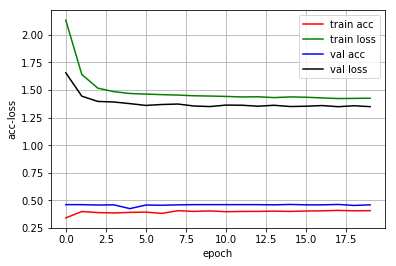

In [14]:
from sklearn.utils import shuffle

mergeData()
train=readData()
train=changeYear(train)
train=augFeatures(train)
train=manage(train)

temp=train
train=np.array(train)
train=normalize(train)
train=pd.DataFrame(train)
train=train.rename(columns = {0:'開盤價',1:'最高價',2:'最低價',3:'收盤價',4:'年',5:'月',6:'日',7:'第幾日'})
train_x1, train_y1 = buildTrain(train,30,1)
train_x2, train_y2 = buildTrain(temp,30,1)
#train_x1= np.reshape(train_x1, (train_x1.shape[0],train_x1.shape[2]))
#train_x1=normalize(train_x1)
#train_x1= np.reshape(train_x1, (train_x1.shape[0],1,train_x1.shape[1]))
train_x, train_y = train_x1,train_y2

train_x, train_y = shuffle1(train_x, train_y )

train_x, train_y , val_x, val_y = splitData(train_x, train_y , 0.1)

train_y=np_utils.to_categorical(train_y)
val_y=np_utils.to_categorical(val_y)

#train_x= np.reshape(train_x, (train_x.shape[0],train_x.shape[2]))
#val_x= np.reshape(val_x, (val_x.shape[0],val_x.shape[2]))

history = LossHistory()
model = buildOneToOneModel(train_x.shape)



#callback = EarlyStopping(monitor="acc", patience=10, verbose=1, mode="auto")

model.fit(train_x, train_y, epochs=20, batch_size=100,verbose=2, validation_split=0.1,callbacks=[history])

history.loss_plot('epoch')


In [12]:
import matplotlib.pyplot as plt
import keras
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
 
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
 
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
 
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

